In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import random

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import matplotlib.pyplot as plt

In [3]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    except:
        pass

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import librosa
import numpy as np
import random

In [7]:
import IPython
from scipy.io.wavfile import read,write
from pylab import plot,show,subplot,specgram, figure

## Utils

In [8]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entity='loss'):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="{}".format(self.entity))
        plt.plot(self.x, self.val_losses, label="val_{}".format(self.entity))
        plt.legend()
        plt.show();

In [9]:
def sliding(feature, window_size=120, stride=10, keep_last=True):
    length = feature.shape[1]
    count = 0
    result = []
    while length > 0:
        start = stride*count
        end = np.minimum(stride*count+window_size, feature.shape[1])
#         if not keep_last and (end - start < window_size) and (start - stride + window_size != feature.shape[1]):
#             break
        if not keep_last and (end - start < window_size):
            break
        feature_temp = feature[:, start:end, np.newaxis]
        length -= stride
        count += 1
        result.append(feature_temp)
        if end - start < window_size:
            break
    return result

In [10]:
def chop(feature, chop_length=500):
    length = feature.shape[1]
    if length < chop_length:
        diff = chop_length-length
        # padding = np.zeros((feature.shape[0], diff, feature.shape[2]))
        padding = np.random.random((feature.shape[0], diff, feature.shape[2])) / 1e6
        return np.concatenate((feature, padding), axis=1)
    elif length >= chop_length:
        diff = length-chop_length
        return feature[:,(diff//2):(diff//2+chop_length),:]

## Load data

In [11]:
all_paths = []
all_label = []
with open("/home/hunglt16/reading_150/nam.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(1)
with open("/home/hunglt16/reading_150/nu.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(0)
print("total: {}".format(len(all_paths)))
x_train, x_val, y_gender_train, y_gender_val = train_test_split(all_paths, all_label, test_size=0.1)

total: 89085


In [12]:
all_paths = []
all_label = []
with open("/home/hunglt16/reading_150/MienBac.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(2)
with open("/home/hunglt16/reading_150/MienTrung.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(1)
with open("/home/hunglt16/reading_150/MienNam.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(0)
print("total: {}".format(len(all_paths)))
x_train, x_val, y_train, y_val = train_test_split(all_paths, all_label, test_size=0.1)

total: 22591


[0.03686523 0.02532959 0.02484131 ... 0.00024414 0.00033569 0.00048828]
(44304,)


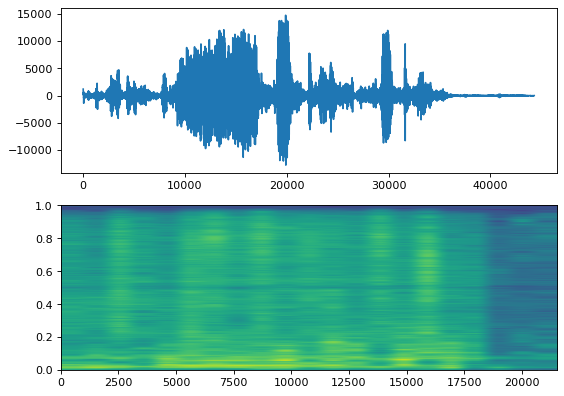

NU


In [13]:
index = random.choice(range(len(all_paths))) 
file = all_paths[index]
label = all_label[index]
signal, _ = librosa.load(
    "/home/hunglt16/reading_150/"+file,
    sr=16000,
    mono=True,
    offset=0.0,
    res_type='kaiser_best',
)
print(signal)
print(signal.shape)

rate,data = read("/home/hunglt16/reading_150/"+file)

figure(figsize=(8, 6), dpi=80)
subplot(211)
plot(range(len(data)),data)
subplot(212)
specgram(data, NFFT=2048, noverlap=0)

show()
if label==0:
    print("NU")
else:
    print("NAM")
IPython.display.Audio("/home/hunglt16/reading_150/"+file)

In [14]:
def load_audio(root, file, n_mfcc=13):
    signal, _ = librosa.load(
        os.path.join(root, file),
        sr=16000,
        mono=True,
        offset=0.0,
        res_type='kaiser_best',
    )
    feature = librosa.feature.mfcc(
        signal,
        sr=16000,
        S=None,
        hop_length=160,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm="ortho",
        lifter=0,
        n_mels=128,
        fmin=0.0,
        fmax=None,
        htk=False,
    )
    feature[feature == 0] = 0.000001
    feature[feature == -np.Inf] = -30
    feature[feature == np.NaN] = -30
    feature[feature == np.Inf] = 0
    feature = np.transpose(feature)
    feature = feature[np.newaxis,:,:]
    return feature

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_ids, labels_1, labels_2, batch_size=64, time_step=500, dim=13,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.time_step = time_step
        self.dim = dim
        self.input_shape = (time_step, dim)
        self.batch_size = batch_size
        self.labels_1 = labels_1
        self.labels_2 = labels_2
        self.list_ids = list_ids
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_ids))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of ids
        list_ids_temp = [self.list_ids[k] for k in indexes]
        list_labels_temp_1 = [self.labels_1[k] for k in indexes]
        list_labels_temp_2 = [self.labels_1[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_ids_temp, list_labels_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp, list_label_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        # X = np.array([])
        # y = np.array([])
        X = np.empty((self.batch_size, *self.input_shape))
        y1 = np.empty(self.batch_size, dtype=int)
        y2 = np.empty(self.batch_size, dtype=int)

        # Generate data
        for i, (ID, label) in enumerate(zip(list_ids_temp, list_label_temp)):
            # Store sample
            x = load_audio(audio_path, ID, n_mfcc=self.dim)
            x = chop(x, chop_length=self.time_step)
            x[x == 0] = 0.000001
            x[x == -np.Inf] = -30
            x[x != x] = -30
            x[x == np.Inf] = 0
            X[i, ] = x
    
            # Store class
            y[i] = label
            keras.utils.to_categorical(y, num_classes=self.n_classes)

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [16]:
def batch_generator(x, y, batch_size, is_train):
    sample_idx = 0
    while True:
        X = np.zeros((batch_size, input_height, input_width, n_channels), dtype='float32')
        y1 = np.zeros((batch_size, mask_height, mask_width), dtype='float32')
        y2 = np.zeros((batch_size, 1), dtype='float32')
        
        X = np.empty((batch_size, *input_shape), dtype='float32')
        y1 = np.empty(batch_size, dtype='float32')
        y2 = np.empty(batch_size, dtype='float32')

        # fill up the batch
        for row in range(batch_size):
            
            image = x[sample_idx]
            mask = y[0][sample_idx]
            binary_value = y[1][sample_idx]
            # transform/preprocess image
            image = cv2.resize(image, (input_width, input_height))
            if is_train:
                image, mask = my_data_augmentation_function(image, mask)
            X_batch[row, ;, :, :] = image
            y1_batch[row, :, :] = mask
            y2_batch[row, 0] = binary_value
            
            x = load_audio(audio_path,  n_mfcc=self.dim)
            x = chop(x, chop_length=self.time_step)
            x[x == 0] = 0.000001
            x[x == -np.Inf] = -30
            x[x != x] = -30
            x[x == np.Inf] = 0
            X[i, ] = x
    
            # Store class
            y[i] = label
            keras.utils.to_categorical(y, num_classes=self.n_classes)
            
            sample_idx += 1

        
        yield(X_batch, {'output1': y1_batch, 'output2': y2_batch} ))

SyntaxError: invalid syntax (225620985.py, line 22)

In [15]:
batch_size=64
time_step=500
dim=13
n_classes=2

In [16]:
audio_path = "/home/hunglt16/data/reading_150"

training_generator = DataGenerator(x_train,
                                   y_train,
                                   batch_size=64,
                                   time_step=500,
                                   dim=13,
                                   n_classes=2)
validation_generator = DataGenerator(x_val, 
                                     y_val,
                                     batch_size=64,
                                     time_step=500,
                                     dim=13,
                                     n_classes=2)

## Model

Model 1

In [17]:
def model_1(batch_size, time_step, dim, n_classes=2):
    input_shape = (time_step, dim)
    inputs = layers.Input(shape=input_shape, batch_size=batch_size)
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='very_smol_nn')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.99)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model 2

In [18]:
def model_2(batch_size, time_step, dim, n_classes=2):
    input_shape = (time_step, dim)
    inputs = layers.Input(shape=input_shape, batch_size=batch_size)
#     x = layers.Flatten()(inputs)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu',
                     input_shape=input_shape[1:])(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64,kernel_size=(3,3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax')
#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adadelta',
#                   metrics=['accuracy'])
    model = models.Model(inputs, outputs, name='cnn_2D')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.99)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

Model 3 - multitask

In [19]:
class StatsPooling(layers.Layer):
    def __init__(self):
        super(StatsPooling, self).__init__()
#         self.outputs = tf.Variable(initial_value=tf.zeros((2*input_dim,)), dtype=tf.float32, trainable=False)
#         self.outputs = tf.Variable(dtype=tf.float32, trainable=False) validate_shape is set to False

    def call(self, inputs):
#         self.mean = tf.math.reduce_mean(inputs, axis=-2)
#         self.std = tf.math.reduce_std(inputs, axis=-2)
        self.mean, self.std = tf.nn.moments(inputs, axes=-2)
        self.outputs = tf.concat([self.mean, self.std],-1)
        return self.outputs
    

def model_3(batch_size, time_step, dim, n_classes=2):
    input_shape = (time_step, dim)
    inputs = layers.Input(shape=input_shape, batch_size=batch_size)
#     x = layers.Flatten()(inputs)
    x = layers.Conv1D(128, 15, strides=3, activation='relu', input_shape=input_shape)(inputs)
    x = layers.Conv1D(128, 5, strides=2, activation='relu', input_shape=input_shape)(x)
    x = layers.Conv1D(128, 3, strides=2, activation='relu', input_shape=input_shape)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = StatsPooling()(x)
    
    # Age branch
#     x1 = layers.Dense(128, activation='relu')(x)
#     age = layers.Dense(3, activation='softmax', name='age_output')(x1)
    
    # Gender branch
    x2 = layers.Dense(128, activation='relu')(x)
    gender = layers.Dense(2, actiation='softmax', name='gender_output')(x2)
    
    # Accent branch
    x3 = layers.Dense(128, activation='relu')(x)
    acccent = layers.Dense(3, activation='softmax', name='accent_output')(x3)
    
    model = models.Model(inputs, outputs=[age, gender, accent], name='smol_xvec')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.99)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss={'gender_ouput': 'categorical_crossentropy',
#                         'age_output': 'categorical_crossentropy',                        
                        'accent_output': 'categorical_crossentropy'},
                  loss_weights={'gender_input': 1,
#                                 'age_input': 1,
                               'accent_input': 1},
                  optimizer=opt, metrics=['accuracy'])

    return model

Model 4

In [20]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = layers.Conv1D(filters, 3, padding="same")(x)
        x = layers.Activation(activation)(x)
    x = layers.Conv1D(filters, 3, padding="same")(x)
    x = layers.Add()([x, s])
    x = layers.Activation(activation)(x)
    return layers.MaxPool1D(pool_size=2, strides=2)(x)


def model_4(batch_size, time_step, dim, n_classes=2):
    input_shape = (time_step, dim)
    inputs = layers.Input(shape=input_shape, batch_size=batch_size)

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)

    outputs = layers.Dense(n_classes, activation="softmax", name="output")(x)
    model = models.Model(inputs, outputs, name='another_model')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=10000,
        decay_rate=0.99)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [21]:
model = model_3(batch_size, time_step, dim, n_classes)
model.summary()

Model: "smol_xvec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 500, 13)]           0         
_________________________________________________________________
conv1d (Conv1D)              (64, 162, 128)            25088     
_________________________________________________________________
conv1d_1 (Conv1D)            (64, 79, 128)             82048     
_________________________________________________________________
conv1d_2 (Conv1D)            (64, 39, 128)             49280     
_________________________________________________________________
dense (Dense)                (64, 39, 128)             16512     
_________________________________________________________________
stats_pooling (StatsPooling) (64, 256)                 0         
_________________________________________________________________
dense_1 (Dense)              (64, 64)                  16

2021-11-04 08:55:57.475506: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-04 08:55:57.475737: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
checkpoint_path = "/home/hunglt16/very_smol_nn_accent.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback = ModelCheckpoint(filepath=checkpoint_path,
                           monitor="val_loss",
                           save_best_only=True,
                           save_weights_only=True,
                           verbose=1)

In [23]:
history = model.fit(training_generator,
                    epochs=10, 
                    validation_data=validation_generator,
                    callbacks=[callback],
                    max_queue_size=32)

2021-11-04 08:55:58.238286: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1252/1252 [==============================] - 1017s 812ms/step - loss: 0.6018 - accuracy: 0.8173 - val_loss: 0.3150 - val_accuracy: 0.8725

Epoch 00001: val_loss improved from inf to 0.31500, saving model to /home/hunglt16/very_smol_nn_accent.h5
Epoch 2/10
1252/1252 [==============================] - 990s 791ms/step - loss: 0.2980 - accuracy: 0.8806 - val_loss: 0.2819 - val_accuracy: 0.8884

Epoch 00002: val_loss improved from 0.31500 to 0.28194, saving model to /home/hunglt16/very_smol_nn_accent.h5
Epoch 3/10
1252/1252 [==============================] - 1034s 826ms/step - loss: 0.2717 - accuracy: 0.8953 - val_loss: 0.2683 - val_accuracy: 0.8973

Epoch 00003: val_loss improved from 0.28194 to 0.26835, saving model to /home/hunglt16/very_smol_nn_accent.h5
Epoch 4/10
1252/1252 [==============================] - 1050s 839ms/step - loss: 0.2558 - accuracy: 0.9031 - val_loss: 0.2637 - val_accuracy: 0.9012

Epoch 00004: val_loss improved from 0.26835 to 0.26367, saving model to /ho

In [24]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (64, 500, 13), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'} []
{'name': 'conv1d', 'trainable': True, 'batch_input_shape': (None, 500, 13), 'dtype': 'float32', 'filters': 128, 'kernel_size': (15,), 'strides': (3,), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[ 0.03698508,  0.0469335 , -0.03235151, ..., -0.04664764,
         -0.02493463,  0.01688706],
        [ 0.03620414, -0.04621223, -0.02696453, ..., -0.05048766,
          0.02896779,  0.00279093],
        [-0.04190093,  0.06112836, -0.01225555, ...,  0.04751131,
         -0.04458928,  0.02695751],
        ...,
        [-0.

In [25]:
for i in range(64):
    data = training_generator[1][0][i]
    
    print(data.shape)
    plt.figure(figsize=(20, 10), constrained_layout=False)
    plt.imshow(data.transpose(1, 0))
    plt.show()
    


(500, 13)


NameError: name 'plt' is not defined